<h1> 主要内容 </h1>

1. 总体策略代码  
2. 策略回测  

In [3]:
#导入模块
import numpy as np
import pandas as pd
import talib

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.finance import candlestick2_ohlc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 50)

#函数：获取数据，设置索引
def get_data(filename):
    data=pd.read_excel(filename)
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.set_index('datetime')
    return data


#函数：高频数据汇总成低频数据，通过resample函数重采样，ohlc()函数生成指定列的open,high,low,close四个汇总字段
def high_2_Low(tmp, freq):
    """
    tmp:含Open,High,Low,Close,Volume字段的数据
    freq:目标频率：
    """
    # 分别处理bar数据
    tmp_open = tmp['Open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['High'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['Low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['Close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)

    # 处理成交量
    tmp_volume = tmp['Volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    res= pd.concat([tmp_price, tmp_volume], axis=1)
    res=res[['open','high','low','close','Volume']]
    res.columns=['Open','High','Low','Close','Volume']
    return res

#函数：计算众多指标
def get_factors(data,
                drop=False):
    '''
    :param data: 含Open,High,Low,Close,Volume字段的带时间索引的数据表格
    :return:
    '''
    index=data.index
    Open =data.Open.astype(float).values
    High =data.High.astype(float).values
    Low  =data.Low.astype(float).values
    Close=data.Close.astype(float).values
    Volume=data.Volume.astype(float).values
    
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index

    #-------------------基本变量-------------------
    tmp['open'] = Open
    tmp['high'] = High
    tmp['low']  = Low
    tmp['close']= Close
    tmp['volume']=Volume
    tmp['log_return']=np.log(tmp['close']/tmp['close'].shift(1))
    tmp['volume_diff']=tmp['volume'].diff()
    
    # 累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    # 用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(High, Low, Close, Volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(High, Low, Close, timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(High, Low, Close, timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    # Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(High, Low, timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(High, Low, timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    # 是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14'] = talib.ATR(High, Low, Close, timeperiod=14)
    tmp['ATR6']  = talib.ATR(High, Low, Close, timeperiod=6)

    # 布林带
    tmp['Boll_Up'], tmp['Boll_Mid'], tmp['Boll_Down'] = talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2,
                                                                     matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(Open, High, Low, Close)

    # 5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    tmp['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    tmp['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    tmp['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(Close, timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(Close, timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(Close, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(High, Low, Close, timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(Close, timeperiod=6)
    tmp['EMA12'] = talib.EMA(Close, timeperiod=12)
    tmp['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    tmp['MACD_DIF'], tmp['MACD_DEA'], tmp['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close, timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(High, Low, timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    # 减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(High, Low, Close, timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    # 从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(High, Low, Close, timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod=26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(Close, timeperiod=6)
    tmp['ROC20'] = talib.ROC(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(Volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(Volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(Close, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(Close, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(High, Low, Close)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(Close, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)

    if drop:
        tmp.dropna(inplace=True)

    tmp.set_index('tradeTime', inplace=True)

    return tmp

#函数：一般的标准化
def get_roll_std(df,rolling=26):
    '''
    :param df:       需要标准化的dataframe
    :param rolling:  是否要rolling(rolling>0则rolling，否则不做）
    :return: 
    '''
    _df=df.copy(deep=True)
    
    factors_list=_df.columns.tolist()

    if rolling>0:
        for i in factors_list:
            _df[i] = (_df[i] - _df[i].rolling(window=rolling, center=False).mean()) / _df[i].rolling(window=rolling, center=False).std()
    else:
        for i in factors_list:
            _df[i] = (_df[i] - _df[i].mean()) / _df[i].std()
            
    _df.dropna(how='any',inplace=True)
    return _df
            


#函数：打标签（极少数无波动的标签为0的去掉）
def get_labeling(closeseries, bar_num):
    '''
    :param closeseries:   bar的收盘价序列
    :param bar_num:       后N根bar
    :return:  label序列  
    '''
    ret=closeseries.shift(-bar_num)/closeseries - 1.0  #后N bar的收益率
    ret=ret.dropna(how='any')
    bin=np.sign(ret.values)
    bin=pd.Series(bin,index=ret.index)
    bin=bin[bin!=0.0]
    return bin

#函数：数据预处理，劈分训练测试集
def data_preprocess(df,featList,split):
    
    if not('bin' in featList):
        featList += ['bin']
        
    _df=df[featList].copy(deep=True)
    _split=int(len(df)*split)
    Xtrain,Xtest = _df.drop(['bin'],1).iloc[:-_split],_df.drop(['bin'],1).iloc[-_split:] #x部分必须删掉标签
    ytrain,ytest = _df['bin'].reindex(Xtrain.index),_df['bin'].reindex(Xtest.index)
    
    return Xtrain,Xtest,ytrain,ytest

#函数：画图
def plot_pic(data):
    plt.figure(figsize=[16,12])
    plt.plot(data['Close'], label='Price')
    #打印抬头
    plt.title('Price')
    
#函数：主要流程
def create_model():
    filename='C:\\HiData\\Users\\ShenHong\\合作\\融秀\\AI量化初级\\notebook\\SHFE_ru_HOT_5.xlsx'
    
    print('读取数据...')
    data=get_data(filename)
    print('记录数=%d'%len(data))
    print()
    
    print('计算指标...')
    factor=get_factors(data,drop=True)
    print()
    
    print('打标签...')
    leb=get_labeling(data['Close'],6)
    leb.name='bin'
    print('y标签序列：')
    print(leb)
    print()
    
    # 我们采用随机森林属于树模型，不一定要用标准化，这里不标准化
    # print('rolling标准化...')
    # bars=get_roll_std(factor,500)
    # print(bars[-10:])
    bars=factor
    
    all=pd.concat([bars,leb],1)
    all.dropna(how='any',inplace=True)
    #以下属性选取了02.Working_with_data&feature.ipynb属性重要性章节对属性排名前N名
    featList=[
        'open','close',
        'high','low',
        'volume_diff',
        'log_return',
        'ADXR',
        'AD',
        'CCI88',
        'OBV',
        'ADX',
        'AROONOSC',
        'WILLR',
        'ADOSC',
        'ULTOSC',
        'MiNUS_DI',
        'DX',
        'NATR',
        'PLUS_DI',
        'MACD_bar',
        'ATR14',
        'APO',
        'MACD_DEA',
        'BOP',
        'CCI5',
        'MiNUS_DM',
        'PLUS_DM',
        'PPO',
        'ATR6',
        'CCI20',
        'MACD_DIF',
        'CCI10',
        'AROONDown',
        'ROC20',
        'CMO_Open'
    ]
    
    Xtrain,Xtest,ytrain,ytest=data_preprocess(all,featList,0.2)
    print('训练样本数=%d，测试样本数=%d'%(len(Xtrain),len(Xtest)))
    print()
    
    #随机森林模型
    clf2=RandomForestClassifier(n_estimators=30,criterion='entropy')
    clf_fit2=clf2.fit(Xtrain.values,ytrain.values) #训练
    
    ypred_rf=clf_fit2.predict(Xtest.values)   #预测分类
    yprob_rf=clf_fit2.predict_proba(Xtest.values) #预测不同类概率
    
    acc=accuracy_score(ytest,ypred_rf)
    
    print('随机森林预测准确率=%f'%acc)
    
    return Xtest,clf_fit2
    
#生成模型
Xtest,model=create_model()

读取数据...


记录数=71720

计算指标...



打标签...
y标签序列：
datetime
2014-05-05 09:05:00    1.0
2014-05-05 09:10:00    1.0
2014-05-05 09:15:00   -1.0
2014-05-05 09:20:00   -1.0
2014-05-05 09:25:00   -1.0
2014-05-05 09:30:00   -1.0
2014-05-05 09:35:00    1.0
                      ... 
2018-11-09 11:10:00   -1.0
2018-11-09 11:15:00   -1.0
2018-11-09 11:20:00   -1.0
2018-11-09 11:25:00    1.0
2018-11-09 11:30:00    1.0
2018-11-09 13:35:00    1.0
2018-11-09 13:40:00    1.0
Name: bin, Length: 68074, dtype: float64



训练样本数=54392，测试样本数=13598



随机森林预测准确率=0.538976


<h1>2.回测 </h1>  

所谓回测，是对已经训练好的模型进行样本外模拟运行测试，考察策略在实际情况中的收益率、夏普比率、回撤情况等指标。  

回测可以通过很多方法实现，可以自己写回测程序，也可以使用一些免费的回测平台，比如掘金量化平台等。这里，为了方便

整合进notebook，我们将采用自己写回测程序的方式。

回测中有一个重要的评价指标：  

1.策略收益率：

策略收益率就是策略回测期间收益率的大小，这是最直接看赚不赚钱的指标。  

2.夏普比率：  

夏普比率（Sharpe Ratio），又被称为夏普指数 --- 基金绩效评价标准化指标。夏普比率就是一个可以同时对收益与风险加  

以综合考虑的三大经典指标之一。 投资中有一个常规的特点，即投资标的的预期报酬越高，投资人所能忍受的波动风险越高；  

反之，预期报酬越低，波动风险也越低。所以理性的投资人选择投资标的与投资组合的主要目的为：在固定所能承受的风险下  

，追求最大的报酬；或在固定的预期报酬下，追求最低的风险。  

计算公式：  

![](https://gss1.bdstatic.com/-vo3dSag_xI4khGkpoWK1HF6hhy/baike/s%3D190/sign=269b2f5106b30f24319ae80af895d192/a08b87d6277f9e2f5a1a99381630e924b899f3d7.jpg "夏普比率") 

其中E(Rp)：投资组合预期报酬率  
Rf：无风险利率  
σp：投资组合的标准差  

3.最大回撤率

最大回撤率：在选定周期内任一历史时点往后推，产品净值走到最低点时的收益率回撤幅度的最大值。最大回撤用来描述买入产品后

可能出现的最糟糕的情况。最大回撤是一个重要的风险指标，对于对冲基金和数量化策略交易，该指标比波动率还重要。

开多，时间=2017-12-21 14:30:00，量=5


止盈止损平仓，时间=2017-12-21 21:05:00，量=5，净值=499500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-21 21:25:00，量=5


止盈止损平仓，时间=2017-12-22 09:05:00，量=5，净值=492000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-22 09:10:00，量=5


止盈止损平仓，时间=2017-12-22 13:35:00，量=5，净值=499000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-22 13:40:00，量=5


止盈止损平仓，时间=2017-12-22 21:05:00，量=5，净值=501500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-22 21:20:00，量=5


止盈止损平仓，时间=2017-12-25 09:05:00，量=5，净值=509250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-25 09:15:00，量=5


止盈止损平仓，时间=2017-12-25 13:35:00，量=5，净值=505500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-25 13:40:00，量=5


止盈止损平仓，时间=2017-12-25 21:05:00，量=5，净值=498000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-25 21:20:00，量=5


止盈止损平仓，时间=2017-12-26 09:05:00，量=5，净值=494750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-26 09:15:00，量=5


止盈止损平仓，时间=2017-12-26 13:35:00，量=5，净值=508500.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-26 13:40:00，量=5


止盈止损平仓，时间=2017-12-26 21:05:00，量=5，净值=510500.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-26 21:20:00，量=5


止盈止损平仓，时间=2017-12-27 09:05:00，量=5，净值=509750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-27 09:10:00，量=5


止盈止损平仓，时间=2017-12-27 13:35:00，量=5，净值=509500.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-27 13:45:00，量=5


止盈止损平仓，时间=2017-12-27 21:10:00，量=5，净值=515750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-27 21:15:00，量=6


止盈止损平仓，时间=2017-12-28 09:05:00，量=6，净值=516350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-28 09:10:00，量=6


止盈止损平仓，时间=2017-12-28 13:35:00，量=6，净值=510650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2017-12-28 13:45:00，量=5


止盈止损平仓，时间=2017-12-28 21:05:00，量=5，净值=512650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-28 21:25:00，量=6


止盈止损平仓，时间=2017-12-29 09:05:00，量=6，净值=507850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-29 09:25:00，量=5


止盈止损平仓，时间=2017-12-29 13:35:00，量=5，净值=504850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2017-12-29 13:40:00，量=5


止盈止损平仓，时间=2018-01-02 09:05:00，量=5，净值=511600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-02 09:20:00，量=5


止盈止损平仓，时间=2018-01-02 13:35:00，量=5，净值=510850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-02 13:45:00，量=5


止盈止损平仓，时间=2018-01-02 21:10:00，量=5，净值=512350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-02 21:30:00，量=5


止盈止损平仓，时间=2018-01-03 09:05:00，量=5，净值=514600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-03 09:25:00，量=5


止盈止损平仓，时间=2018-01-03 13:35:00，量=5，净值=513600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-03 13:55:00，量=5


止盈止损平仓，时间=2018-01-03 21:05:00，量=5，净值=508100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-03 21:20:00，量=5


止盈止损平仓，时间=2018-01-04 09:05:00，量=5，净值=510350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-04 09:10:00，量=6


止盈止损平仓，时间=2018-01-04 13:35:00，量=6，净值=506450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-04 13:40:00，量=5


止盈止损平仓，时间=2018-01-04 21:05:00，量=5，净值=508200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-04 21:30:00，量=6


止盈止损平仓，时间=2018-01-05 09:05:00，量=6，净值=506400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-05 09:15:00，量=6


止盈止损平仓，时间=2018-01-05 13:40:00，量=6，净值=505800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-05 13:45:00，量=6


止盈止损平仓，时间=2018-01-05 21:05:00，量=6，净值=503400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-05 21:15:00，量=5


止盈止损平仓，时间=2018-01-08 09:05:00，量=5，净值=505650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-08 09:15:00，量=5


止盈止损平仓，时间=2018-01-08 13:35:00，量=5，净值=503650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-08 14:05:00，量=5


止盈止损平仓，时间=2018-01-08 21:05:00，量=5，净值=499900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-08 21:30:00，量=5


止盈止损平仓，时间=2018-01-09 09:20:00，量=5，净值=498650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-09 09:25:00，量=5


止盈止损平仓，时间=2018-01-09 13:35:00，量=5，净值=498150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-09 13:40:00，量=5


止盈止损平仓，时间=2018-01-09 21:05:00，量=5，净值=496150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-09 21:15:00，量=5


止盈止损平仓，时间=2018-01-10 09:05:00，量=5，净值=498900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-10 09:40:00，量=5


止盈止损平仓，时间=2018-01-10 13:40:00，量=5，净值=499150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-10 14:25:00，量=5


止盈止损平仓，时间=2018-01-10 21:10:00，量=5，净值=499900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-10 21:15:00，量=5


止盈止损平仓，时间=2018-01-11 09:05:00，量=5，净值=500900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-11 09:10:00，量=5


止盈止损平仓，时间=2018-01-11 13:35:00，量=5，净值=498400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-11 14:10:00，量=5


止盈止损平仓，时间=2018-01-11 21:05:00，量=5，净值=502650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-11 21:15:00，量=5


止盈止损平仓，时间=2018-01-12 09:05:00，量=5，净值=509900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-12 09:10:00，量=5


止盈止损平仓，时间=2018-01-12 13:35:00，量=5，净值=511150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-12 13:40:00，量=5


止盈止损平仓，时间=2018-01-12 21:05:00，量=5，净值=508150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-12 21:15:00，量=5


止盈止损平仓，时间=2018-01-15 09:05:00，量=5，净值=511900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-15 09:10:00，量=5


止盈止损平仓，时间=2018-01-15 13:35:00，量=5，净值=516900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-15 13:40:00，量=5


止盈止损平仓，时间=2018-01-15 21:05:00，量=5，净值=517150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-15 21:15:00，量=5


止盈止损平仓，时间=2018-01-16 09:05:00，量=5，净值=516900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-16 09:15:00，量=6


止盈止损平仓，时间=2018-01-16 13:35:00，量=6，净值=517500.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-16 13:40:00，量=6


止盈止损平仓，时间=2018-01-16 21:05:00，量=6，净值=525600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-16 21:10:00，量=6


止盈止损平仓，时间=2018-01-17 09:05:00，量=6，净值=529200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-17 09:20:00，量=6


止盈止损平仓，时间=2018-01-17 13:35:00，量=6，净值=530100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-17 13:40:00，量=6


止盈止损平仓，时间=2018-01-17 21:05:00，量=6，净值=527700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-17 21:20:00，量=6


止盈止损平仓，时间=2018-01-18 09:10:00，量=6，净值=528000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-18 09:25:00，量=6


止盈止损平仓，时间=2018-01-18 13:35:00，量=6，净值=525300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-18 13:40:00，量=6


止盈止损平仓，时间=2018-01-18 21:05:00，量=6，净值=531000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-18 21:30:00，量=6


止盈止损平仓，时间=2018-01-19 09:05:00，量=6，净值=530700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-19 09:15:00，量=6


止盈止损平仓，时间=2018-01-19 13:35:00，量=6，净值=540000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-19 13:40:00，量=6


止盈止损平仓，时间=2018-01-19 21:05:00，量=6，净值=540000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-19 21:10:00，量=6


止盈止损平仓，时间=2018-01-22 09:05:00，量=6，净值=541500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-22 09:20:00，量=6


止盈止损平仓，时间=2018-01-22 13:35:00，量=6，净值=543600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-22 13:40:00，量=6


止盈止损平仓，时间=2018-01-22 21:05:00，量=6，净值=542400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-22 21:45:00，量=6


止盈止损平仓，时间=2018-01-23 09:05:00，量=6，净值=542700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-23 09:40:00，量=6


止盈止损平仓，时间=2018-01-23 13:40:00，量=6，净值=557700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-23 13:55:00，量=6


止盈止损平仓，时间=2018-01-23 21:05:00，量=6，净值=561300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-23 21:10:00，量=6


止盈止损平仓，时间=2018-01-24 09:05:00，量=6，净值=561300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-24 09:10:00，量=6


止盈止损平仓，时间=2018-01-24 13:35:00，量=6，净值=563100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-24 13:40:00，量=6


止盈止损平仓，时间=2018-01-24 21:10:00，量=6，净值=562800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-24 21:30:00，量=6


止盈止损平仓，时间=2018-01-25 09:05:00，量=6，净值=563100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-25 09:30:00，量=6


止盈止损平仓，时间=2018-01-25 13:35:00，量=6，净值=562500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-25 14:00:00，量=6


止盈止损平仓，时间=2018-01-25 21:05:00，量=6，净值=559800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-25 21:10:00，量=6


止盈止损平仓，时间=2018-01-26 09:05:00，量=6，净值=562800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-26 09:10:00，量=6


止盈止损平仓，时间=2018-01-26 13:35:00，量=6，净值=563700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-26 13:55:00，量=6


止盈止损平仓，时间=2018-01-26 21:05:00，量=6，净值=561900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-26 21:30:00，量=6


止盈止损平仓，时间=2018-01-29 09:05:00，量=6，净值=561600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-29 09:10:00，量=6


止盈止损平仓，时间=2018-01-29 13:35:00，量=6，净值=561300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-29 13:40:00，量=6


止盈止损平仓，时间=2018-01-29 21:05:00，量=6，净值=561600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-29 21:40:00，量=6


止盈止损平仓，时间=2018-01-30 09:05:00，量=6，净值=561900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-30 09:20:00，量=6


止盈止损平仓，时间=2018-01-30 13:35:00，量=6，净值=563400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-30 13:50:00，量=6


止盈止损平仓，时间=2018-01-30 21:05:00，量=6，净值=556800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-30 21:10:00，量=6


止盈止损平仓，时间=2018-01-31 09:05:00，量=6，净值=544800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-31 09:15:00，量=6


止盈止损平仓，时间=2018-01-31 13:35:00，量=6，净值=540600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-01-31 14:00:00，量=6


止盈止损平仓，时间=2018-01-31 21:05:00，量=6，净值=543300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-01-31 21:25:00，量=6


止盈止损平仓，时间=2018-02-01 09:05:00，量=6，净值=542700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-01 09:10:00，量=6


止盈止损平仓，时间=2018-02-01 13:35:00，量=6，净值=540900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-01 13:40:00，量=6


止盈止损平仓，时间=2018-02-01 21:05:00，量=6，净值=538800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-01 21:20:00，量=6


止盈止损平仓，时间=2018-02-02 09:05:00，量=6，净值=539700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-02 09:20:00，量=6


止盈止损平仓，时间=2018-02-02 13:35:00，量=6，净值=539700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-02 13:55:00，量=6


止盈止损平仓，时间=2018-02-02 21:05:00，量=6，净值=543600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-02 21:10:00，量=6


止盈止损平仓，时间=2018-02-05 09:05:00，量=6，净值=541200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-05 09:10:00，量=6


止盈止损平仓，时间=2018-02-05 13:35:00，量=6，净值=544500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-05 13:45:00，量=6


止盈止损平仓，时间=2018-02-05 21:05:00，量=6，净值=546000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-05 21:10:00，量=6


止盈止损平仓，时间=2018-02-06 09:05:00，量=6，净值=553200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-06 09:20:00，量=7


止盈止损平仓，时间=2018-02-06 13:35:00，量=7，净值=557750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-06 13:45:00，量=7


止盈止损平仓，时间=2018-02-06 21:05:00，量=7，净值=556000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-06 21:15:00，量=7


止盈止损平仓，时间=2018-02-07 09:05:00，量=7，净值=561250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-07 09:15:00，量=7


止盈止损平仓，时间=2018-02-07 13:35:00，量=7，净值=556700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-07 13:50:00，量=7


止盈止损平仓，时间=2018-02-07 21:05:00，量=7，净值=560200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-07 21:10:00，量=7


止盈止损平仓，时间=2018-02-08 09:05:00，量=7，净值=575250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-08 09:10:00，量=7


止盈止损平仓，时间=2018-02-08 13:35:00，量=7，净值=572800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-08 13:45:00，量=7


止盈止损平仓，时间=2018-02-08 21:05:00，量=7，净值=574550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-08 21:10:00，量=7


止盈止损平仓，时间=2018-02-09 09:05:00，量=7，净值=578400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-09 09:15:00，量=7


止盈止损平仓，时间=2018-02-09 13:35:00，量=7，净值=585750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-09 13:55:00，量=7


止盈止损平仓，时间=2018-02-09 21:05:00，量=7，净值=584700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-09 21:20:00，量=7


止盈止损平仓，时间=2018-02-12 09:05:00，量=7，净值=591000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-12 09:15:00，量=7


止盈止损平仓，时间=2018-02-12 13:35:00，量=7，净值=582950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-12 13:55:00，量=7


止盈止损平仓，时间=2018-02-12 21:05:00，量=7，净值=581550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-12 21:10:00，量=7


止盈止损平仓，时间=2018-02-13 09:05:00，量=7，净值=575600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-13 09:20:00，量=7


止盈止损平仓，时间=2018-02-13 13:35:00，量=7，净值=584700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-13 13:50:00，量=7


止盈止损平仓，时间=2018-02-13 21:05:00，量=7，净值=580150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-13 21:10:00，量=7


止盈止损平仓，时间=2018-02-14 09:05:00，量=7，净值=581200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-14 09:10:00，量=7


止盈止损平仓，时间=2018-02-14 13:35:00，量=7，净值=580150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-14 13:40:00，量=7


止盈止损平仓，时间=2018-02-22 09:05:00，量=7，净值=582600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-22 09:15:00，量=7


止盈止损平仓，时间=2018-02-22 13:35:00，量=7，净值=590300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-22 13:45:00，量=7


止盈止损平仓，时间=2018-02-22 21:05:00，量=7，净值=595550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-22 21:10:00，量=7


止盈止损平仓，时间=2018-02-23 09:05:00，量=7，净值=585050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-23 09:10:00，量=7


止盈止损平仓，时间=2018-02-23 13:35:00，量=7，净值=584000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-23 13:50:00，量=7


止盈止损平仓，时间=2018-02-23 21:05:00，量=7，净值=582600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-23 21:20:00，量=7


止盈止损平仓，时间=2018-02-26 09:05:00，量=7，净值=577350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-26 09:25:00，量=7


止盈止损平仓，时间=2018-02-26 13:35:00，量=7，净值=577350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-26 13:45:00，量=7


止盈止损平仓，时间=2018-02-26 21:05:00，量=7，净值=577000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-26 21:15:00，量=7


止盈止损平仓，时间=2018-02-27 09:05:00，量=7，净值=575600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-27 09:20:00，量=7


止盈止损平仓，时间=2018-02-27 13:35:00，量=7，净值=572800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-27 14:00:00，量=7


止盈止损平仓，时间=2018-02-27 21:05:00，量=7，净值=573500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-27 21:15:00，量=7


止盈止损平仓，时间=2018-02-28 09:05:00，量=7，净值=575600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-02-28 09:10:00，量=7


止盈止损平仓，时间=2018-02-28 13:35:00，量=7，净值=586450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-28 13:40:00，量=7


止盈止损平仓，时间=2018-02-28 21:05:00，量=7，净值=583300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-02-28 21:15:00，量=7


止盈止损平仓，时间=2018-03-01 09:05:00，量=7，净值=587500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-01 09:15:00，量=7


止盈止损平仓，时间=2018-03-01 13:35:00，量=7，净值=594150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-01 13:50:00，量=7


止盈止损平仓，时间=2018-03-01 21:05:00，量=7，净值=590300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-01 21:35:00，量=7


止盈止损平仓，时间=2018-03-02 09:05:00，量=7，净值=593450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-02 09:10:00，量=7


止盈止损平仓，时间=2018-03-02 13:35:00，量=7，净值=598700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-02 13:40:00，量=7


止盈止损平仓，时间=2018-03-02 21:05:00，量=7，净值=602200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-02 21:15:00，量=7


止盈止损平仓，时间=2018-03-05 09:05:00，量=7，净值=596250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-05 09:15:00，量=7


止盈止损平仓，时间=2018-03-05 13:35:00，量=7，净值=597300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-05 13:40:00，量=7


止盈止损平仓，时间=2018-03-05 21:05:00，量=7，净值=598700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-05 21:50:00，量=7


止盈止损平仓，时间=2018-03-06 09:05:00，量=7，净值=591350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-06 09:10:00，量=7


止盈止损平仓，时间=2018-03-06 13:35:00，量=7，净值=593100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-06 14:10:00，量=7


止盈止损平仓，时间=2018-03-06 21:05:00，量=7，净值=596600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-06 21:10:00，量=7


止盈止损平仓，时间=2018-03-07 09:05:00，量=7，净值=596600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-07 09:20:00，量=7


止盈止损平仓，时间=2018-03-07 13:35:00，量=7，净值=598350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-07 13:40:00，量=7


止盈止损平仓，时间=2018-03-07 21:05:00，量=7，净值=597300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-07 21:10:00，量=7


止盈止损平仓，时间=2018-03-08 09:05:00，量=7，净值=601850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-08 09:10:00，量=7


止盈止损平仓，时间=2018-03-08 13:35:00，量=7，净值=599050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-08 13:40:00，量=7


止盈止损平仓，时间=2018-03-08 21:05:00，量=7，净值=602900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-08 21:15:00，量=7


止盈止损平仓，时间=2018-03-09 09:05:00，量=7，净值=599750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-09 09:10:00，量=7


止盈止损平仓，时间=2018-03-09 13:40:00，量=7，净值=574200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-09 14:05:00，量=7


止盈止损平仓，时间=2018-03-09 21:05:00，量=7，净值=574550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-09 21:45:00，量=7


止盈止损平仓，时间=2018-03-12 09:05:00，量=7，净值=579100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-12 09:15:00，量=7


止盈止损平仓，时间=2018-03-12 13:35:00，量=7，净值=579800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-12 13:40:00，量=7


止盈止损平仓，时间=2018-03-12 21:05:00，量=7，净值=582950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-12 21:25:00，量=7


止盈止损平仓，时间=2018-03-13 09:05:00，量=7，净值=582600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-13 09:20:00，量=7


止盈止损平仓，时间=2018-03-13 13:35:00，量=7，净值=582950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-13 13:45:00，量=7


止盈止损平仓，时间=2018-03-13 21:05:00，量=7，净值=578750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-13 21:20:00，量=7


止盈止损平仓，时间=2018-03-14 09:05:00，量=7，净值=573150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-14 09:20:00，量=7


止盈止损平仓，时间=2018-03-14 13:35:00，量=7，净值=568600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-14 13:40:00，量=7


止盈止损平仓，时间=2018-03-14 21:05:00，量=7，净值=570700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-14 21:40:00，量=7


止盈止损平仓，时间=2018-03-15 09:05:00，量=7，净值=565100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-15 09:50:00，量=7


止盈止损平仓，时间=2018-03-15 13:50:00，量=7，净值=566150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-15 14:20:00，量=7


止盈止损平仓，时间=2018-03-15 21:05:00，量=7，净值=566500.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-15 21:10:00，量=7


止盈止损平仓，时间=2018-03-16 09:05:00，量=7，净值=573850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-16 09:15:00，量=7


止盈止损平仓，时间=2018-03-16 13:35:00，量=7，净值=569650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-16 13:40:00，量=7


止盈止损平仓，时间=2018-03-16 21:05:00，量=7，净值=572450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-16 21:10:00，量=7


止盈止损平仓，时间=2018-03-19 09:05:00，量=7，净值=563700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-19 09:10:00，量=7


止盈止损平仓，时间=2018-03-19 13:35:00，量=7，净值=565100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-19 13:55:00，量=7


止盈止损平仓，时间=2018-03-19 21:10:00，量=7，净值=563700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-19 21:30:00，量=7


止盈止损平仓，时间=2018-03-20 09:05:00，量=7，净值=556700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-20 09:10:00，量=7


止盈止损平仓，时间=2018-03-20 13:35:00，量=7，净值=536400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-20 13:45:00，量=7


止盈止损平仓，时间=2018-03-20 21:05:00，量=7，净值=539200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-20 21:20:00，量=7


止盈止损平仓，时间=2018-03-21 09:05:00，量=7，净值=541650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-21 09:15:00，量=7


止盈止损平仓，时间=2018-03-21 13:35:00，量=7，净值=550400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-21 13:45:00，量=7


止盈止损平仓，时间=2018-03-21 21:05:00，量=7，净值=550050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-21 21:15:00，量=7


止盈止损平仓，时间=2018-03-22 09:05:00，量=7，净值=558100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-22 09:20:00，量=7


止盈止损平仓，时间=2018-03-22 13:35:00，量=7，净值=560900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-22 13:50:00，量=7


止盈止损平仓，时间=2018-03-22 21:05:00，量=7，净值=557050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-22 21:10:00，量=7


止盈止损平仓，时间=2018-03-23 09:25:00，量=7，净值=502100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-23 10:15:00，量=7
止盈止损平仓，时间=2018-03-23 14:35:00，量=7，净值=498600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-23 14:40:00，量=7


止盈止损平仓，时间=2018-03-23 21:05:00，量=7，净值=511550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-23 21:15:00，量=7


止盈止损平仓，时间=2018-03-26 09:05:00，量=7，净值=500350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-26 09:10:00，量=7


止盈止损平仓，时间=2018-03-26 13:35:00，量=7，净值=500700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-26 14:05:00，量=7


止盈止损平仓，时间=2018-03-26 21:05:00，量=7，净值=499650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-26 21:20:00，量=7


止盈止损平仓，时间=2018-03-27 09:05:00，量=7，净值=490900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-27 09:45:00，量=7


止盈止损平仓，时间=2018-03-27 13:45:00，量=7，净值=488800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-27 13:55:00，量=7


止盈止损平仓，时间=2018-03-27 21:05:00，量=7，净值=487750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-27 21:25:00，量=7


止盈止损平仓，时间=2018-03-28 09:05:00，量=7，净值=473750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-28 09:10:00，量=7


止盈止损平仓，时间=2018-03-28 13:40:00，量=7，净值=485650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-28 13:55:00，量=7


止盈止损平仓，时间=2018-03-28 21:05:00，量=7，净值=512600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-28 21:10:00，量=7


止盈止损平仓，时间=2018-03-29 09:05:00，量=7，净值=511200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-29 09:10:00，量=7


止盈止损平仓，时间=2018-03-29 13:35:00，量=7，净值=512250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-29 13:40:00，量=7


止盈止损平仓，时间=2018-03-29 21:05:00，量=7，净值=509800.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-03-29 21:20:00，量=7


止盈止损平仓，时间=2018-03-30 09:05:00，量=7，净值=516450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-30 09:10:00，量=7


止盈止损平仓，时间=2018-03-30 13:35:00，量=7，净值=525200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-30 14:00:00，量=7


止盈止损平仓，时间=2018-03-30 21:05:00，量=7，净值=521350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-03-30 21:10:00，量=7


止盈止损平仓，时间=2018-04-02 09:05:00，量=7，净值=521700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-02 09:10:00，量=7


止盈止损平仓，时间=2018-04-02 13:35:00，量=7，净值=525900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-02 13:45:00，量=7


止盈止损平仓，时间=2018-04-02 21:05:00，量=7，净值=529400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-02 21:20:00，量=7


止盈止损平仓，时间=2018-04-03 09:05:00，量=7，净值=525200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-03 09:10:00，量=7


止盈止损平仓，时间=2018-04-03 13:35:00，量=7，净值=520300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-03 13:45:00，量=7


止盈止损平仓，时间=2018-04-03 21:05:00，量=7，净值=518900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-03 21:10:00，量=7


止盈止损平仓，时间=2018-04-04 09:05:00，量=7，净值=514700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-04 09:25:00，量=7


止盈止损平仓，时间=2018-04-04 13:35:00，量=7，净值=512950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-04 13:55:00，量=7


止盈止损平仓，时间=2018-04-09 09:05:00，量=7，净值=512950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-09 09:25:00，量=7


止盈止损平仓，时间=2018-04-09 13:35:00，量=7，净值=512250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-09 13:40:00，量=7


止盈止损平仓，时间=2018-04-09 21:05:00，量=7，净值=511900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-09 21:10:00，量=7


止盈止损平仓，时间=2018-04-10 09:05:00，量=7，净值=511900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-10 09:15:00，量=7


止盈止损平仓，时间=2018-04-10 13:35:00，量=7，净值=512950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-10 13:55:00，量=7


止盈止损平仓，时间=2018-04-10 21:05:00，量=7，净值=515050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-10 21:10:00，量=7


止盈止损平仓，时间=2018-04-11 09:05:00，量=7，净值=507000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-11 09:15:00，量=7


止盈止损平仓，时间=2018-04-11 13:35:00，量=7，净值=513300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-11 13:40:00，量=7


止盈止损平仓，时间=2018-04-11 21:05:00，量=7，净值=512950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-11 21:15:00，量=7


止盈止损平仓，时间=2018-04-12 09:05:00，量=7，净值=510500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-12 09:10:00，量=7


止盈止损平仓，时间=2018-04-12 13:35:00，量=7，净值=509100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-12 13:50:00，量=7


止盈止损平仓，时间=2018-04-12 21:05:00，量=7，净值=514000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-12 21:10:00，量=7


止盈止损平仓，时间=2018-04-13 09:05:00，量=7，净值=511900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-13 09:10:00，量=7


止盈止损平仓，时间=2018-04-13 13:35:00，量=7，净值=516450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-13 13:45:00，量=7


止盈止损平仓，时间=2018-04-13 21:05:00，量=7，净值=517500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-13 21:20:00，量=7


止盈止损平仓，时间=2018-04-16 09:05:00，量=7，净值=512950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-16 09:10:00，量=7


止盈止损平仓，时间=2018-04-16 13:35:00，量=7，净值=490200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-16 13:40:00，量=7


止盈止损平仓，时间=2018-04-16 21:05:00，量=7，净值=495800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-16 21:20:00，量=7


止盈止损平仓，时间=2018-04-17 09:05:00，量=7，净值=491600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-17 09:10:00，量=7


止盈止损平仓，时间=2018-04-17 13:35:00，量=7，净值=492650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-17 13:40:00，量=7


止盈止损平仓，时间=2018-04-17 21:05:00，量=7，净值=490550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-17 21:10:00，量=7


止盈止损平仓，时间=2018-04-18 09:05:00，量=7，净值=487400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-18 09:40:00，量=7


止盈止损平仓，时间=2018-04-18 13:40:00，量=7，净值=488450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-18 13:50:00，量=7


止盈止损平仓，时间=2018-04-18 21:05:00，量=7，净值=494400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-18 21:10:00，量=7


止盈止损平仓，时间=2018-04-19 09:05:00，量=7，净值=491250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-19 09:20:00，量=7


止盈止损平仓，时间=2018-04-19 13:35:00，量=7，净值=463250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-19 13:40:00，量=6


止盈止损平仓，时间=2018-04-19 21:05:00，量=6，净值=466250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-19 21:45:00，量=6


止盈止损平仓，时间=2018-04-20 09:05:00，量=6，净值=469850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-20 09:20:00，量=6


止盈止损平仓，时间=2018-04-20 13:35:00，量=6，净值=465050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-20 13:45:00，量=6


止盈止损平仓，时间=2018-04-20 21:05:00，量=6，净值=466550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-20 21:10:00，量=6


止盈止损平仓，时间=2018-04-23 09:05:00，量=6，净值=463550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-23 09:20:00，量=6


止盈止损平仓，时间=2018-04-23 13:35:00，量=6，净值=465950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-23 13:40:00，量=6


止盈止损平仓，时间=2018-04-23 21:05:00，量=6，净值=478250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-23 21:10:00，量=6


止盈止损平仓，时间=2018-04-24 09:05:00，量=6，净值=477050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-04-24 09:20:00，量=6


止盈止损平仓，时间=2018-04-24 13:35:00，量=6，净值=473750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-24 13:45:00，量=6


止盈止损平仓，时间=2018-04-24 21:05:00，量=6，净值=471350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-24 21:15:00，量=6


止盈止损平仓，时间=2018-04-25 09:05:00，量=6，净值=471350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-25 09:10:00，量=6


止盈止损平仓，时间=2018-04-25 13:35:00，量=6，净值=476150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-25 14:30:00，量=6


止盈止损平仓，时间=2018-04-25 21:05:00，量=6，净值=474650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-25 21:15:00，量=6


止盈止损平仓，时间=2018-04-26 09:05:00，量=6，净值=471350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-26 09:10:00，量=6


止盈止损平仓，时间=2018-04-26 13:35:00，量=6，净值=465950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-26 13:40:00，量=6


止盈止损平仓，时间=2018-04-26 21:05:00，量=6，净值=467450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-26 21:10:00，量=6


止盈止损平仓，时间=2018-04-27 09:05:00，量=6，净值=468050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-27 09:15:00，量=6


止盈止损平仓，时间=2018-04-27 13:35:00，量=6，净值=457850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-04-27 13:50:00，量=6


止盈止损平仓，时间=2018-05-02 09:05:00，量=6，净值=467750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-02 09:25:00，量=6


止盈止损平仓，时间=2018-05-02 13:35:00，量=6，净值=465950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-02 13:40:00，量=6


止盈止损平仓，时间=2018-05-02 21:05:00，量=6，净值=456350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-02 21:10:00，量=6


止盈止损平仓，时间=2018-05-03 09:05:00，量=6，净值=458750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-03 09:25:00，量=6


止盈止损平仓，时间=2018-05-03 13:35:00，量=6，净值=458450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-03 13:55:00，量=6


止盈止损平仓，时间=2018-05-03 21:05:00，量=6，净值=462950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-03 21:30:00，量=6


止盈止损平仓，时间=2018-05-04 09:10:00，量=6，净值=458750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-04 09:30:00，量=6


止盈止损平仓，时间=2018-05-04 13:35:00，量=6，净值=457250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-04 13:55:00，量=6


止盈止损平仓，时间=2018-05-04 21:05:00，量=6，净值=458450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-04 21:10:00，量=6


止盈止损平仓，时间=2018-05-07 09:05:00，量=6，净值=462050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-07 09:10:00，量=6


止盈止损平仓，时间=2018-05-07 13:35:00，量=6，净值=452450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-07 13:40:00，量=6


止盈止损平仓，时间=2018-05-07 21:05:00，量=6，净值=453350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-07 21:15:00，量=6


止盈止损平仓，时间=2018-05-08 09:05:00，量=6，净值=450650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-08 09:10:00，量=6


止盈止损平仓，时间=2018-05-08 13:35:00，量=6，净值=452750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-08 14:00:00，量=6


止盈止损平仓，时间=2018-05-08 21:10:00，量=6，净值=447650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-08 21:25:00，量=6


止盈止损平仓，时间=2018-05-09 09:05:00，量=6，净值=444350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-09 09:10:00，量=6


止盈止损平仓，时间=2018-05-09 13:35:00，量=6，净值=445250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-09 13:50:00，量=6


止盈止损平仓，时间=2018-05-09 21:10:00，量=6，净值=450650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-09 21:25:00，量=6


止盈止损平仓，时间=2018-05-10 09:05:00，量=6，净值=451850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-10 09:30:00，量=6


止盈止损平仓，时间=2018-05-10 13:35:00，量=6，净值=444650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-10 13:45:00，量=6


止盈止损平仓，时间=2018-05-10 21:05:00，量=6，净值=450050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-10 21:10:00，量=6


止盈止损平仓，时间=2018-05-11 09:05:00，量=6，净值=451250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-11 09:15:00，量=6


止盈止损平仓，时间=2018-05-11 13:35:00，量=6，净值=451550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-11 13:40:00，量=6


止盈止损平仓，时间=2018-05-11 21:05:00，量=6，净值=453050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-11 21:10:00，量=6


止盈止损平仓，时间=2018-05-14 09:05:00，量=6，净值=458450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-14 09:10:00，量=6


止盈止损平仓，时间=2018-05-14 13:35:00，量=6，净值=459350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-14 13:50:00，量=6


止盈止损平仓，时间=2018-05-14 21:05:00，量=6，净值=453950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-14 21:10:00，量=6


止盈止损平仓，时间=2018-05-15 09:05:00，量=6，净值=453950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-15 09:10:00，量=6


止盈止损平仓，时间=2018-05-15 13:40:00，量=6，净值=442250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-15 13:50:00，量=6


止盈止损平仓，时间=2018-05-15 21:05:00，量=6，净值=440150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-15 21:10:00，量=6


止盈止损平仓，时间=2018-05-16 09:05:00，量=6，净值=442850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-16 09:10:00，量=6


止盈止损平仓，时间=2018-05-16 13:35:00，量=6，净值=447650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-16 13:45:00，量=6


止盈止损平仓，时间=2018-05-16 21:05:00，量=6，净值=444950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-16 21:10:00，量=6


止盈止损平仓，时间=2018-05-17 09:05:00，量=6，净值=442850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-17 09:20:00，量=6


止盈止损平仓，时间=2018-05-17 13:35:00，量=6，净值=442850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-17 14:00:00，量=6


止盈止损平仓，时间=2018-05-17 21:05:00，量=6，净值=442550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-17 21:10:00，量=6


止盈止损平仓，时间=2018-05-18 09:05:00，量=6，净值=453950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-18 09:15:00，量=6


止盈止损平仓，时间=2018-05-18 13:35:00，量=6，净值=457850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-18 13:45:00，量=6


止盈止损平仓，时间=2018-05-18 21:05:00，量=6，净值=460550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-18 21:25:00，量=6


止盈止损平仓，时间=2018-05-21 09:05:00，量=6，净值=467150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-21 09:20:00，量=6


止盈止损平仓，时间=2018-05-21 13:35:00，量=6，净值=483350.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-21 13:40:00，量=6


止盈止损平仓，时间=2018-05-21 21:05:00，量=6，净值=490250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-21 21:10:00，量=6


止盈止损平仓，时间=2018-05-22 09:05:00，量=6，净值=491450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-22 09:10:00，量=6


止盈止损平仓，时间=2018-05-22 13:35:00，量=6，净值=495350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-22 13:40:00，量=6


止盈止损平仓，时间=2018-05-22 21:05:00，量=6，净值=496850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-22 21:10:00，量=6


止盈止损平仓，时间=2018-05-23 09:05:00，量=6，净值=493850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-23 09:10:00，量=6


止盈止损平仓，时间=2018-05-23 13:35:00，量=6，净值=471050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-23 13:40:00，量=6


止盈止损平仓，时间=2018-05-23 21:05:00，量=6，净值=475850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-23 21:10:00，量=6


止盈止损平仓，时间=2018-05-24 09:05:00，量=6，净值=475850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-24 09:10:00，量=6


止盈止损平仓，时间=2018-05-24 13:35:00，量=6，净值=473450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-24 13:40:00，量=6


止盈止损平仓，时间=2018-05-24 21:05:00，量=6，净值=476150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-24 21:20:00，量=6


止盈止损平仓，时间=2018-05-25 09:05:00，量=6，净值=479150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-25 09:10:00，量=6


止盈止损平仓，时间=2018-05-25 13:35:00，量=6，净值=481250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-25 14:05:00，量=6


止盈止损平仓，时间=2018-05-25 21:05:00，量=6，净值=484850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-25 21:15:00，量=6


止盈止损平仓，时间=2018-05-28 09:05:00，量=6，净值=478250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-28 09:10:00，量=6


止盈止损平仓，时间=2018-05-28 13:35:00，量=6，净值=475550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-28 13:40:00，量=6


止盈止损平仓，时间=2018-05-28 21:05:00，量=6，净值=476450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-28 21:15:00，量=6


止盈止损平仓，时间=2018-05-29 09:05:00，量=6，净值=479750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-29 09:10:00，量=6


止盈止损平仓，时间=2018-05-29 13:35:00，量=6，净值=467450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-29 13:40:00，量=6


止盈止损平仓，时间=2018-05-29 21:05:00，量=6，净值=468950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-29 21:10:00，量=6


止盈止损平仓，时间=2018-05-30 09:05:00，量=6，净值=452750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-30 09:20:00，量=6


止盈止损平仓，时间=2018-05-30 13:35:00，量=6，净值=452750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-30 14:10:00，量=6


止盈止损平仓，时间=2018-05-30 21:05:00，量=6，净值=446750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-30 21:10:00，量=6


止盈止损平仓，时间=2018-05-31 09:05:00，量=6，净值=453050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-31 09:25:00，量=6


止盈止损平仓，时间=2018-05-31 13:35:00，量=6，净值=451550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-05-31 13:55:00，量=6


止盈止损平仓，时间=2018-05-31 21:05:00，量=6，净值=456350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-05-31 21:10:00，量=6


止盈止损平仓，时间=2018-06-01 09:05:00，量=6，净值=458450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-01 09:55:00，量=6


止盈止损平仓，时间=2018-06-01 14:00:00，量=6，净值=462950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-01 14:10:00，量=6


止盈止损平仓，时间=2018-06-01 21:05:00，量=6，净值=465650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-01 21:20:00，量=6


止盈止损平仓，时间=2018-06-04 09:05:00，量=6，净值=465950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-04 10:10:00，量=6


止盈止损平仓，时间=2018-06-04 14:10:00，量=6，净值=466550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-04 14:15:00，量=6


止盈止损平仓，时间=2018-06-04 21:05:00，量=6，净值=468050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-04 21:25:00，量=6


止盈止损平仓，时间=2018-06-05 09:05:00，量=6，净值=468650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-05 09:20:00，量=6


止盈止损平仓，时间=2018-06-05 13:35:00，量=6，净值=451550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-05 14:10:00，量=6


止盈止损平仓，时间=2018-06-05 21:05:00，量=6，净值=453050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-05 21:40:00，量=6


止盈止损平仓，时间=2018-06-06 09:05:00，量=6，净值=455450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-06 09:20:00，量=6


止盈止损平仓，时间=2018-06-06 13:35:00，量=6，净值=453950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-06 14:00:00，量=6


止盈止损平仓，时间=2018-06-06 21:05:00，量=6，净值=457850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-06 21:15:00，量=6


止盈止损平仓，时间=2018-06-07 09:05:00，量=6，净值=454550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-07 09:15:00，量=6


止盈止损平仓，时间=2018-06-07 13:35:00，量=6，净值=454550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-07 13:45:00，量=6


止盈止损平仓，时间=2018-06-07 21:05:00，量=6，净值=454250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-07 21:25:00，量=6


止盈止损平仓，时间=2018-06-08 09:05:00，量=6，净值=458150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-08 09:20:00，量=6


止盈止损平仓，时间=2018-06-08 13:35:00，量=6，净值=454250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-08 13:40:00，量=6


止盈止损平仓，时间=2018-06-08 21:05:00，量=6，净值=453650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-08 21:10:00，量=6


止盈止损平仓，时间=2018-06-11 09:05:00，量=6，净值=454550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-11 09:15:00，量=6


止盈止损平仓，时间=2018-06-11 13:45:00，量=6，净值=455450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-11 13:55:00，量=6


止盈止损平仓，时间=2018-06-11 21:05:00，量=6，净值=454850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-11 21:30:00，量=6


止盈止损平仓，时间=2018-06-12 09:10:00，量=6，净值=456050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-12 09:15:00，量=6


止盈止损平仓，时间=2018-06-12 13:35:00，量=6，净值=453650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-12 13:45:00，量=6


止盈止损平仓，时间=2018-06-12 21:05:00，量=6，净值=452450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-12 21:10:00，量=6


止盈止损平仓，时间=2018-06-13 09:05:00，量=6，净值=436550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-13 09:10:00，量=6


止盈止损平仓，时间=2018-06-13 13:35:00，量=6，净值=423950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-13 13:45:00，量=6


止盈止损平仓，时间=2018-06-13 21:05:00，量=6，净值=427850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-13 21:25:00，量=6


止盈止损平仓，时间=2018-06-14 09:05:00，量=6，净值=433250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-14 09:15:00，量=6


止盈止损平仓，时间=2018-06-14 13:35:00，量=6，净值=438350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-14 13:45:00，量=6


止盈止损平仓，时间=2018-06-14 21:05:00，量=6，净值=447650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-14 21:10:00，量=6


止盈止损平仓，时间=2018-06-15 09:05:00，量=6，净值=450050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-15 09:10:00，量=6


止盈止损平仓，时间=2018-06-15 13:35:00，量=6，净值=446750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-15 13:40:00，量=6


止盈止损平仓，时间=2018-06-19 09:05:00，量=6，净值=436550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-19 09:10:00，量=6


止盈止损平仓，时间=2018-06-19 13:35:00，量=6，净值=415850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-19 13:45:00，量=6


止盈止损平仓，时间=2018-06-19 21:05:00，量=6，净值=414050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-19 21:15:00，量=6


止盈止损平仓，时间=2018-06-20 09:05:00，量=6，净值=410150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-20 09:10:00，量=6


止盈止损平仓，时间=2018-06-20 13:35:00，量=6，净值=413750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-20 13:40:00，量=6


止盈止损平仓，时间=2018-06-20 21:05:00，量=6，净值=416150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-20 21:25:00，量=6


止盈止损平仓，时间=2018-06-21 09:05:00，量=6，净值=417350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-21 09:30:00，量=6


止盈止损平仓，时间=2018-06-21 13:40:00，量=6，净值=413150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-21 13:45:00，量=6


止盈止损平仓，时间=2018-06-21 21:05:00，量=6，净值=416750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-21 22:25:00，量=6
止盈止损平仓，时间=2018-06-22 09:05:00，量=6，净值=419450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-22 09:10:00，量=6


止盈止损平仓，时间=2018-06-22 13:35:00，量=6，净值=424850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-22 13:40:00，量=6


止盈止损平仓，时间=2018-06-22 21:05:00，量=6，净值=430850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-22 21:40:00，量=6


止盈止损平仓，时间=2018-06-25 09:05:00，量=6，净值=428150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-25 09:15:00，量=6


止盈止损平仓，时间=2018-06-25 13:35:00，量=6，净值=422150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-25 13:40:00，量=6


止盈止损平仓，时间=2018-06-25 21:05:00，量=6，净值=423650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-25 21:10:00，量=6


止盈止损平仓，时间=2018-06-26 09:05:00，量=6，净值=430550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-26 09:10:00，量=6


止盈止损平仓，时间=2018-06-26 13:40:00，量=6，净值=443450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-26 13:50:00，量=7


止盈止损平仓，时间=2018-06-26 21:05:00，量=7，净值=443450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-26 21:10:00，量=7


止盈止损平仓，时间=2018-06-27 09:05:00，量=7，净值=445550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-27 09:10:00，量=7


止盈止损平仓，时间=2018-06-27 13:40:00，量=7，净值=448000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-27 13:45:00，量=7


止盈止损平仓，时间=2018-06-27 21:05:00，量=7，净值=452550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-27 21:35:00，量=7


止盈止损平仓，时间=2018-06-28 09:10:00，量=7，净值=450450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-28 09:25:00，量=7


止盈止损平仓，时间=2018-06-28 13:35:00，量=7，净值=449050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-28 13:45:00，量=7


止盈止损平仓，时间=2018-06-28 21:05:00，量=7，净值=454300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-06-28 21:10:00，量=7


止盈止损平仓，时间=2018-06-29 09:05:00，量=7，净值=459900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-29 09:15:00，量=7


止盈止损平仓，时间=2018-06-29 13:35:00，量=7，净值=460250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-29 13:50:00，量=7


止盈止损平仓，时间=2018-06-29 21:10:00，量=7，净值=463050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-06-29 21:15:00，量=7


止盈止损平仓，时间=2018-07-02 09:05:00，量=7，净值=462700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-02 09:10:00，量=7


止盈止损平仓，时间=2018-07-02 13:35:00，量=7，净值=478450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-02 13:40:00，量=7


止盈止损平仓，时间=2018-07-02 21:10:00，量=7，净值=479150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-02 21:15:00，量=7


止盈止损平仓，时间=2018-07-03 09:05:00，量=7，净值=483350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-03 09:20:00，量=7


止盈止损平仓，时间=2018-07-03 13:35:00，量=7，净值=485800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-03 13:50:00，量=7


止盈止损平仓，时间=2018-07-03 21:05:00，量=7，净值=487550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-03 21:10:00，量=7


止盈止损平仓，时间=2018-07-04 09:05:00，量=7，净值=494550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-04 09:10:00，量=7


止盈止损平仓，时间=2018-07-04 13:35:00，量=7，净值=488950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-04 13:40:00，量=7


止盈止损平仓，时间=2018-07-04 21:05:00，量=7，净值=491400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-04 21:10:00，量=7


止盈止损平仓，时间=2018-07-05 09:05:00，量=7，净值=488600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-05 09:10:00，量=7


止盈止损平仓，时间=2018-07-05 13:35:00，量=7，净值=497350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-05 13:45:00，量=7


止盈止损平仓，时间=2018-07-05 21:05:00，量=7，净值=498750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-05 21:15:00，量=7


止盈止损平仓，时间=2018-07-06 09:05:00，量=7，净值=502250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-06 09:10:00，量=8


止盈止损平仓，时间=2018-07-06 13:35:00，量=8，净值=501850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-06 13:40:00，量=8


止盈止损平仓，时间=2018-07-06 21:10:00，量=8，净值=505050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-06 21:15:00，量=8


止盈止损平仓，时间=2018-07-09 09:05:00，量=8，净值=512250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-09 09:10:00，量=8


止盈止损平仓，时间=2018-07-09 13:40:00，量=8，净值=523050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-09 13:45:00，量=8


止盈止损平仓，时间=2018-07-09 21:05:00，量=8，净值=526250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-09 21:10:00，量=8


止盈止损平仓，时间=2018-07-10 09:05:00，量=8，净值=525450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-10 09:15:00，量=8


止盈止损平仓，时间=2018-07-10 13:35:00，量=8，净值=535850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-10 13:40:00，量=8


止盈止损平仓，时间=2018-07-10 21:05:00，量=8，净值=535450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-10 21:10:00，量=8


止盈止损平仓，时间=2018-07-11 09:05:00，量=8，净值=549050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-11 09:10:00，量=8


止盈止损平仓，时间=2018-07-11 13:35:00，量=8，净值=553850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-11 13:55:00，量=8


止盈止损平仓，时间=2018-07-11 21:05:00，量=8，净值=558650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-11 21:10:00，量=9


止盈止损平仓，时间=2018-07-12 09:05:00，量=9，净值=552800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-12 09:10:00，量=8


止盈止损平仓，时间=2018-07-12 13:35:00，量=8，净值=560400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-12 14:10:00，量=8


止盈止损平仓，时间=2018-07-12 21:05:00，量=8，净值=563200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-12 21:10:00，量=9


止盈止损平仓，时间=2018-07-13 09:05:00，量=9，净值=554650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-13 09:10:00，量=8


止盈止损平仓，时间=2018-07-13 13:35:00，量=8，净值=556650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-13 13:40:00，量=8


止盈止损平仓，时间=2018-07-13 21:05:00，量=8，净值=553450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-13 21:20:00，量=8


止盈止损平仓，时间=2018-07-16 09:05:00，量=8，净值=554250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-16 09:10:00，量=8


止盈止损平仓，时间=2018-07-16 13:45:00，量=8，净值=555050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-16 13:50:00，量=8


止盈止损平仓，时间=2018-07-16 21:05:00，量=8，净值=555450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-16 21:15:00，量=8


止盈止损平仓，时间=2018-07-17 09:05:00，量=8，净值=556650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-17 09:10:00，量=8


止盈止损平仓，时间=2018-07-17 13:35:00，量=8，净值=545050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-17 13:45:00，量=8


止盈止损平仓，时间=2018-07-17 21:05:00，量=8，净值=540250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-17 21:35:00，量=8


止盈止损平仓，时间=2018-07-18 09:05:00，量=8，净值=538250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-18 09:10:00，量=8


止盈止损平仓，时间=2018-07-18 13:35:00，量=8，净值=537850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-18 13:50:00，量=8


止盈止损平仓，时间=2018-07-18 21:05:00，量=8，净值=541050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-18 21:10:00，量=8


止盈止损平仓，时间=2018-07-19 09:05:00，量=8，净值=540650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-19 09:10:00，量=8


止盈止损平仓，时间=2018-07-19 13:35:00，量=8，净值=552250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-19 14:00:00，量=8


止盈止损平仓，时间=2018-07-19 21:05:00，量=8，净值=551850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-19 21:10:00，量=8


止盈止损平仓，时间=2018-07-20 09:05:00，量=8，净值=551450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-20 09:10:00，量=8


止盈止损平仓，时间=2018-07-20 13:35:00，量=8，净值=551850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-20 13:55:00，量=8


止盈止损平仓，时间=2018-07-20 21:05:00，量=8，净值=549850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-20 21:10:00，量=8


止盈止损平仓，时间=2018-07-23 09:05:00，量=8，净值=552650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-23 09:10:00，量=8


止盈止损平仓，时间=2018-07-23 13:35:00，量=8，净值=547450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-23 13:50:00，量=8


止盈止损平仓，时间=2018-07-23 21:05:00，量=8，净值=549050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-23 21:10:00，量=8


止盈止损平仓，时间=2018-07-24 09:05:00，量=8，净值=553850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-24 09:30:00，量=9


止盈止损平仓，时间=2018-07-24 13:35:00，量=9，净值=555200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-24 13:45:00，量=9


止盈止损平仓，时间=2018-07-24 21:05:00，量=9，净值=553850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-24 21:10:00，量=9


止盈止损平仓，时间=2018-07-25 09:05:00，量=9，净值=569150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-25 09:20:00，量=9


止盈止损平仓，时间=2018-07-25 13:35:00，量=9，净值=571850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-25 13:55:00，量=9


止盈止损平仓，时间=2018-07-25 21:05:00，量=9，净值=575000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-25 21:10:00，量=9


止盈止损平仓，时间=2018-07-26 09:05:00，量=9，净值=577700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-26 09:20:00，量=9


止盈止损平仓，时间=2018-07-26 13:35:00，量=9，净值=579500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-26 13:50:00，量=9


止盈止损平仓，时间=2018-07-26 21:05:00，量=9，净值=580850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-26 21:10:00，量=9


止盈止损平仓，时间=2018-07-27 09:05:00，量=9，净值=581750.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-27 09:15:00，量=9


止盈止损平仓，时间=2018-07-27 13:35:00，量=9，净值=588050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-27 13:40:00，量=9


止盈止损平仓，时间=2018-07-27 21:05:00，量=9，净值=592550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-27 21:10:00，量=9


止盈止损平仓，时间=2018-07-30 09:05:00，量=9，净值=580850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-30 09:10:00，量=9


止盈止损平仓，时间=2018-07-30 13:40:00，量=9，净值=575450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-30 14:00:00，量=9


止盈止损平仓，时间=2018-07-30 21:05:00，量=9，净值=574550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-30 21:15:00，量=9


止盈止损平仓，时间=2018-07-31 09:05:00，量=9，净值=575000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-31 09:15:00，量=9


止盈止损平仓，时间=2018-07-31 13:35:00，量=9，净值=578150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-07-31 14:00:00，量=9


止盈止损平仓，时间=2018-07-31 21:05:00，量=9，净值=588950.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-07-31 21:35:00，量=9


止盈止损平仓，时间=2018-08-01 09:05:00，量=9，净值=595250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-01 09:10:00，量=9


止盈止损平仓，时间=2018-08-01 13:35:00，量=9，净值=593000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-01 13:40:00，量=9


止盈止损平仓，时间=2018-08-01 21:05:00，量=9，净值=590750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-01 21:10:00，量=9


止盈止损平仓，时间=2018-08-02 09:05:00，量=9，净值=587600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-02 09:50:00，量=9


止盈止损平仓，时间=2018-08-02 13:50:00，量=9，净值=587150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-02 13:55:00，量=9


止盈止损平仓，时间=2018-08-02 21:05:00，量=9，净值=590300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-02 21:15:00，量=9


止盈止损平仓，时间=2018-08-03 09:05:00，量=9，净值=598400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-03 09:10:00，量=9


止盈止损平仓，时间=2018-08-03 13:35:00，量=9，净值=593900.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-03 13:40:00，量=9


止盈止损平仓，时间=2018-08-03 21:05:00，量=9，净值=601100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-03 21:10:00，量=9


止盈止损平仓，时间=2018-08-06 09:05:00，量=9，净值=606050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-06 09:15:00，量=9


止盈止损平仓，时间=2018-08-06 13:35:00，量=9，净值=601100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-06 13:50:00，量=9


止盈止损平仓，时间=2018-08-06 21:05:00，量=9，净值=597950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-06 21:15:00，量=9


止盈止损平仓，时间=2018-08-07 09:05:00，量=9，净值=595250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-07 09:40:00，量=9


止盈止损平仓，时间=2018-08-07 13:40:00，量=9，净值=596600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-07 13:50:00，量=9


止盈止损平仓，时间=2018-08-07 21:05:00，量=9，净值=799100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-07 21:10:00，量=10


止盈止损平仓，时间=2018-08-08 09:05:00，量=10，净值=782600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-08 09:15:00，量=10


止盈止损平仓，时间=2018-08-08 13:35:00，量=10，净值=780600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-08 13:45:00，量=10


止盈止损平仓，时间=2018-08-08 21:05:00，量=10，净值=782100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-08 21:10:00，量=10


止盈止损平仓，时间=2018-08-09 09:05:00，量=10，净值=789100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-09 09:35:00，量=10


止盈止损平仓，时间=2018-08-09 13:35:00，量=10，净值=797600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-09 13:40:00，量=10


止盈止损平仓，时间=2018-08-09 21:05:00，量=10，净值=792600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-09 21:25:00，量=10


止盈止损平仓，时间=2018-08-10 09:05:00，量=10，净值=780600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-10 09:15:00，量=10


止盈止损平仓，时间=2018-08-10 13:35:00，量=10，净值=757600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-10 13:55:00，量=10


止盈止损平仓，时间=2018-08-10 21:10:00，量=10，净值=761600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-10 21:15:00，量=10


止盈止损平仓，时间=2018-08-13 09:05:00，量=10，净值=765100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-13 09:10:00，量=10


止盈止损平仓，时间=2018-08-13 13:35:00，量=10，净值=777600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-13 13:50:00，量=10


止盈止损平仓，时间=2018-08-13 21:05:00，量=10，净值=782600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-13 21:10:00，量=10


止盈止损平仓，时间=2018-08-14 09:05:00，量=10，净值=794100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-14 09:10:00，量=10


止盈止损平仓，时间=2018-08-14 13:35:00，量=10，净值=790600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-14 13:40:00，量=10


止盈止损平仓，时间=2018-08-14 21:05:00，量=10，净值=790600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-14 21:10:00，量=10


止盈止损平仓，时间=2018-08-15 09:05:00，量=10，净值=798600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-15 09:35:00，量=10


止盈止损平仓，时间=2018-08-15 13:35:00，量=10，净值=812600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-15 13:40:00，量=10


止盈止损平仓，时间=2018-08-15 21:05:00，量=10，净值=807600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-15 21:10:00，量=10


止盈止损平仓，时间=2018-08-16 09:05:00，量=10，净值=745600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-16 09:20:00，量=10


止盈止损平仓，时间=2018-08-16 13:35:00，量=10，净值=752100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-16 13:45:00，量=10


止盈止损平仓，时间=2018-08-16 21:05:00，量=10，净值=750600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-16 21:10:00，量=10


止盈止损平仓，时间=2018-08-17 09:05:00，量=10，净值=748100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-17 09:10:00，量=10


止盈止损平仓，时间=2018-08-17 13:35:00，量=10，净值=747100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-17 13:45:00，量=10


止盈止损平仓，时间=2018-08-17 21:05:00，量=10，净值=745100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-17 21:10:00，量=10


止盈止损平仓，时间=2018-08-20 09:05:00，量=10，净值=743100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-20 09:10:00，量=10


止盈止损平仓，时间=2018-08-20 13:35:00，量=10，净值=743600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-20 13:40:00，量=10


止盈止损平仓，时间=2018-08-20 21:05:00，量=10，净值=751100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-20 21:20:00，量=10


止盈止损平仓，时间=2018-08-21 09:05:00，量=10，净值=753100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-21 09:15:00，量=10


止盈止损平仓，时间=2018-08-21 13:35:00，量=10，净值=754100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-21 13:40:00，量=10
止盈止损平仓，时间=2018-08-21 14:05:00，量=10，净值=797100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-21 14:10:00，量=10


止盈止损平仓，时间=2018-08-21 21:05:00，量=10，净值=847600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-21 21:35:00，量=11


止盈止损平仓，时间=2018-08-22 09:10:00，量=11，净值=846500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-22 09:15:00，量=11


止盈止损平仓，时间=2018-08-22 13:35:00，量=11，净值=831100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-22 13:40:00，量=11


止盈止损平仓，时间=2018-08-22 21:05:00，量=11，净值=833850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-22 21:15:00，量=11


止盈止损平仓，时间=2018-08-23 09:05:00，量=11，净值=839900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-23 09:10:00，量=11


止盈止损平仓，时间=2018-08-23 13:35:00，量=11，净值=847050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-23 14:00:00，量=11


止盈止损平仓，时间=2018-08-23 21:05:00，量=11，净值=856400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-23 21:10:00，量=11


止盈止损平仓，时间=2018-08-24 09:05:00，量=11，净值=872900.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-24 09:15:00，量=11


止盈止损平仓，时间=2018-08-24 13:35:00，量=11，净值=870700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-24 13:45:00，量=11


止盈止损平仓，时间=2018-08-24 21:05:00，量=11，净值=875100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-24 21:15:00，量=11


止盈止损平仓，时间=2018-08-27 09:05:00，量=11，净值=869600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-27 09:20:00，量=11


止盈止损平仓，时间=2018-08-27 13:35:00，量=11，净值=871250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-27 13:40:00，量=11


止盈止损平仓，时间=2018-08-27 21:10:00，量=11，净值=882800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-27 21:20:00，量=11


止盈止损平仓，时间=2018-08-28 09:05:00，量=11，净值=891600.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-28 09:10:00，量=11


止盈止损平仓，时间=2018-08-28 13:35:00，量=11，净值=908650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-28 13:40:00，量=12


止盈止损平仓，时间=2018-08-28 21:05:00，量=12，净值=900250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-28 21:15:00，量=12


止盈止损平仓，时间=2018-08-29 09:05:00，量=12，净值=909250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-29 09:10:00，量=12


止盈止损平仓，时间=2018-08-29 13:35:00，量=12，净值=912250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-29 14:20:00，量=12


止盈止损平仓，时间=2018-08-29 21:05:00，量=12，净值=921250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-29 21:15:00，量=12


止盈止损平仓，时间=2018-08-30 09:05:00，量=12，净值=923050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-30 09:10:00，量=12


止盈止损平仓，时间=2018-08-30 13:35:00，量=12，净值=926050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-30 13:50:00，量=12


止盈止损平仓，时间=2018-08-30 21:10:00，量=12，净值=930250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-30 21:15:00，量=12


止盈止损平仓，时间=2018-08-31 09:05:00，量=12，净值=918250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-31 09:10:00，量=12


止盈止损平仓，时间=2018-08-31 13:35:00，量=12，净值=921850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-08-31 13:45:00，量=12


止盈止损平仓，时间=2018-08-31 21:05:00，量=12，净值=933250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-08-31 21:10:00，量=12


止盈止损平仓，时间=2018-09-03 09:05:00，量=12，净值=901450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-03 09:15:00，量=12


止盈止损平仓，时间=2018-09-03 13:40:00，量=12，净值=882850.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-03 14:05:00，量=12


止盈止损平仓，时间=2018-09-03 21:05:00，量=12，净值=876250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-03 21:15:00，量=12


止盈止损平仓，时间=2018-09-04 09:05:00，量=12，净值=878650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-04 09:30:00，量=12


止盈止损平仓，时间=2018-09-04 13:35:00，量=12，净值=873850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-04 13:40:00，量=12


止盈止损平仓，时间=2018-09-04 21:05:00，量=12，净值=876850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-04 21:10:00，量=12


止盈止损平仓，时间=2018-09-05 09:05:00，量=12，净值=880450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-05 09:35:00，量=12


止盈止损平仓，时间=2018-09-05 13:35:00，量=12，净值=879850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-05 13:50:00，量=12


止盈止损平仓，时间=2018-09-05 21:05:00，量=12，净值=882850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-05 21:35:00，量=12


止盈止损平仓，时间=2018-09-06 09:05:00，量=12，净值=886450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-06 09:20:00，量=12


止盈止损平仓，时间=2018-09-06 13:35:00，量=12，净值=879850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-06 13:40:00，量=12


止盈止损平仓，时间=2018-09-06 21:05:00，量=12，净值=887050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-06 21:10:00，量=12


止盈止损平仓，时间=2018-09-07 09:05:00，量=12，净值=899050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-07 09:15:00，量=12


止盈止损平仓，时间=2018-09-07 13:35:00，量=12，净值=883450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-07 13:40:00，量=12


止盈止损平仓，时间=2018-09-07 21:05:00，量=12，净值=902050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-07 21:35:00，量=12


止盈止损平仓，时间=2018-09-10 09:05:00，量=12，净值=908050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-10 09:15:00，量=12


止盈止损平仓，时间=2018-09-10 13:35:00，量=12，净值=911050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-10 13:40:00，量=12


止盈止损平仓，时间=2018-09-10 21:05:00，量=12，净值=908050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-10 21:15:00，量=12


止盈止损平仓，时间=2018-09-11 09:05:00，量=12，净值=906250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-11 09:15:00，量=12


止盈止损平仓，时间=2018-09-11 13:35:00，量=12，净值=907450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-11 13:45:00，量=12


止盈止损平仓，时间=2018-09-11 21:05:00，量=12，净值=897250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-11 21:10:00，量=12


止盈止损平仓，时间=2018-09-12 09:05:00，量=12，净值=928450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-12 09:15:00，量=12


止盈止损平仓，时间=2018-09-12 13:35:00，量=12，净值=919450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-12 13:50:00，量=12


止盈止损平仓，时间=2018-09-12 21:05:00，量=12，净值=906250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-12 21:20:00，量=12


止盈止损平仓，时间=2018-09-13 09:05:00，量=12，净值=903250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-13 09:30:00，量=12


止盈止损平仓，时间=2018-09-13 13:35:00，量=12，净值=891250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-13 14:25:00，量=12
止盈止损平仓，时间=2018-09-13 21:05:00，量=12，净值=890650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-13 21:40:00，量=12


止盈止损平仓，时间=2018-09-14 09:05:00，量=12，净值=891250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-14 09:10:00，量=12


止盈止损平仓，时间=2018-09-14 13:35:00，量=12，净值=890650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-14 13:50:00，量=12


止盈止损平仓，时间=2018-09-14 21:05:00，量=12，净值=889450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-14 21:20:00，量=12


止盈止损平仓，时间=2018-09-17 09:05:00，量=12，净值=899050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-17 09:20:00，量=12


止盈止损平仓，时间=2018-09-17 13:35:00，量=12，净值=930250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-17 13:50:00，量=12


止盈止损平仓，时间=2018-09-17 21:05:00，量=12，净值=926050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-17 21:10:00，量=12


止盈止损平仓，时间=2018-09-18 09:05:00，量=12，净值=933850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-18 09:10:00，量=12


止盈止损平仓，时间=2018-09-18 13:35:00，量=12，净值=938650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-18 13:50:00，量=12


止盈止损平仓，时间=2018-09-18 21:05:00，量=12，净值=943450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-18 21:15:00，量=12


止盈止损平仓，时间=2018-09-19 09:05:00，量=12，净值=931450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-19 09:10:00，量=12


止盈止损平仓，时间=2018-09-19 13:35:00，量=12，净值=932050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-19 13:50:00，量=12


止盈止损平仓，时间=2018-09-19 21:05:00，量=12，净值=938650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-19 21:25:00，量=12


止盈止损平仓，时间=2018-09-20 09:05:00，量=12，净值=923650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-20 09:20:00，量=12


止盈止损平仓，时间=2018-09-20 11:20:00，量=12，净值=972250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-20 11:25:00，量=12


止盈止损平仓，时间=2018-09-20 21:05:00，量=12，净值=980050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-20 21:10:00，量=13


止盈止损平仓，时间=2018-09-21 09:05:00，量=13，净值=980700.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-21 09:15:00，量=12


止盈止损平仓，时间=2018-09-21 13:35:00，量=12，净值=995100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-21 13:40:00，量=13


止盈止损平仓，时间=2018-09-25 09:05:00，量=13，净值=1000300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-25 09:10:00，量=13


止盈止损平仓，时间=2018-09-25 13:35:00，量=13，净值=1013300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-25 13:45:00，量=13


止盈止损平仓，时间=2018-09-25 21:05:00，量=13，净值=1021100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-25 21:40:00，量=13


止盈止损平仓，时间=2018-09-26 09:05:00，量=13，净值=1034100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-26 09:15:00，量=13


止盈止损平仓，时间=2018-09-26 13:35:00，量=13，净值=1029550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-26 13:50:00，量=13


止盈止损平仓，时间=2018-09-26 21:05:00，量=13，净值=1028250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-26 21:15:00，量=13


止盈止损平仓，时间=2018-09-27 09:05:00，量=13，净值=1013300.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-27 09:10:00，量=13


止盈止损平仓，时间=2018-09-27 13:35:00，量=13，净值=1011350.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-27 13:45:00，量=13


止盈止损平仓，时间=2018-09-27 21:05:00，量=13，净值=1004200.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-09-27 21:10:00，量=13


止盈止损平仓，时间=2018-09-28 09:05:00，量=13，净值=993150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-28 09:10:00，量=13


止盈止损平仓，时间=2018-09-28 13:35:00，量=13，净值=983400.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-09-28 13:40:00，量=13


止盈止损平仓，时间=2018-10-08 09:05:00，量=13，净值=969100.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-08 09:15:00，量=13


止盈止损平仓，时间=2018-10-08 13:35:00，量=13，净值=961300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-08 13:40:00，量=13


止盈止损平仓，时间=2018-10-08 21:05:00，量=13，净值=958050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-08 21:20:00，量=12


止盈止损平仓，时间=2018-10-09 09:05:00，量=12，净值=974250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-09 09:10:00，量=12


止盈止损平仓，时间=2018-10-09 13:35:00，量=12，净值=966450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-09 13:55:00，量=12


止盈止损平仓，时间=2018-10-09 21:05:00，量=12，净值=962250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-09 21:10:00，量=12


止盈止损平仓，时间=2018-10-10 09:05:00，量=12，净值=956250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-10 09:15:00，量=12


止盈止损平仓，时间=2018-10-10 13:35:00，量=12，净值=952050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-10 13:45:00，量=12


止盈止损平仓，时间=2018-10-10 21:05:00，量=12，净值=956250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-10 21:10:00，量=12


止盈止损平仓，时间=2018-10-11 09:05:00，量=12，净值=913050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-11 09:15:00，量=12


止盈止损平仓，时间=2018-10-11 13:35:00，量=12，净值=913050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-11 13:40:00，量=12


止盈止损平仓，时间=2018-10-11 21:05:00，量=12，净值=911250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-11 21:10:00，量=12


止盈止损平仓，时间=2018-10-12 09:05:00，量=12，净值=913050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-12 09:10:00，量=12


止盈止损平仓，时间=2018-10-12 13:35:00，量=12，净值=919650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-12 13:55:00，量=12


止盈止损平仓，时间=2018-10-12 21:05:00，量=12，净值=913050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-12 21:10:00，量=12


止盈止损平仓，时间=2018-10-15 09:05:00，量=12，净值=908250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-15 09:20:00，量=12


止盈止损平仓，时间=2018-10-15 13:35:00，量=12，净值=905850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-15 13:40:00，量=12


止盈止损平仓，时间=2018-10-15 21:05:00，量=12，净值=907650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-15 21:10:00，量=12


止盈止损平仓，时间=2018-10-16 09:05:00，量=12，净值=904050.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-16 09:25:00，量=12


止盈止损平仓，时间=2018-10-16 13:35:00，量=12，净值=907050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-16 13:45:00，量=12


止盈止损平仓，时间=2018-10-16 21:10:00，量=12，净值=889650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-16 21:15:00，量=12


止盈止损平仓，时间=2018-10-17 09:05:00，量=12，净值=883050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-17 09:10:00，量=12


止盈止损平仓，时间=2018-10-17 13:35:00，量=12，净值=880650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-17 14:00:00，量=11


止盈止损平仓，时间=2018-10-17 21:05:00，量=11，净值=881750.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-17 21:10:00，量=12


止盈止损平仓，时间=2018-10-18 09:05:00，量=12，净值=876950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-18 09:10:00，量=12


止盈止损平仓，时间=2018-10-18 13:35:00，量=12，净值=866150.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-18 13:40:00，量=12


止盈止损平仓，时间=2018-10-18 21:05:00，量=12，净值=855950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-18 21:10:00，量=11


止盈止损平仓，时间=2018-10-19 09:05:00，量=11，净值=859800.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-19 09:10:00，量=11


止盈止损平仓，时间=2018-10-19 13:35:00，量=11，净值=864200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-19 13:50:00，量=11


止盈止损平仓，时间=2018-10-19 21:05:00，量=11，净值=863650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-19 21:30:00，量=11


止盈止损平仓，时间=2018-10-22 09:05:00，量=11，净值=866400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-22 09:30:00，量=11


止盈止损平仓，时间=2018-10-22 13:35:00，量=11，净值=869700.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-22 14:05:00，量=11


止盈止损平仓，时间=2018-10-22 21:05:00，量=11，净值=866950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-22 21:10:00，量=11


止盈止损平仓，时间=2018-10-23 09:05:00，量=11，净值=867500.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-23 09:15:00，量=11


止盈止损平仓，时间=2018-10-23 13:45:00，量=11，净值=857050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-23 13:50:00，量=11


止盈止损平仓，时间=2018-10-23 21:05:00，量=11，净值=851000.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-23 21:15:00，量=11


止盈止损平仓，时间=2018-10-24 09:05:00，量=11，净值=854300.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-24 09:20:00，量=11


止盈止损平仓，时间=2018-10-24 13:35:00，量=11，净值=853200.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-24 13:45:00，量=11


止盈止损平仓，时间=2018-10-24 21:05:00，量=11，净值=851000.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-24 21:10:00，量=11


止盈止损平仓，时间=2018-10-25 09:05:00，量=11，净值=873550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-25 09:10:00，量=12


止盈止损平仓，时间=2018-10-25 13:35:00，量=12，净值=868150.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-25 14:10:00，量=12


止盈止损平仓，时间=2018-10-25 21:05:00，量=12，净值=852550.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-25 21:35:00，量=12


止盈止损平仓，时间=2018-10-26 09:05:00，量=12，净值=845950.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-26 09:10:00，量=11


止盈止损平仓，时间=2018-10-26 13:35:00，量=11，净值=841550.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-26 13:40:00，量=11


止盈止损平仓，时间=2018-10-26 21:05:00，量=11，净值=842100.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-26 21:10:00，量=11


止盈止损平仓，时间=2018-10-29 09:05:00，量=11，净值=856400.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-29 09:15:00，量=12


止盈止损平仓，时间=2018-10-29 13:35:00，量=12，净值=815600.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-29 13:40:00，量=11


止盈止损平仓，时间=2018-10-29 21:05:00，量=11，净值=817250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-29 21:20:00，量=11


止盈止损平仓，时间=2018-10-30 09:05:00，量=11，净值=832650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-30 09:10:00，量=12


止盈止损平仓，时间=2018-10-30 13:40:00，量=12，净值=845250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-30 13:50:00，量=12


止盈止损平仓，时间=2018-10-30 21:05:00，量=12，净值=850050.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-30 21:15:00，量=12


止盈止损平仓，时间=2018-10-31 09:05:00，量=12，净值=836850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-31 09:10:00，量=12


止盈止损平仓，时间=2018-10-31 13:35:00，量=12，净值=838650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-10-31 13:40:00，量=12


止盈止损平仓，时间=2018-10-31 21:05:00，量=12，净值=845250.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-10-31 21:35:00，量=12


止盈止损平仓，时间=2018-11-01 09:05:00，量=12，净值=845250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-01 09:10:00，量=12


止盈止损平仓，时间=2018-11-01 13:35:00，量=12，净值=839850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-01 13:40:00，量=12


止盈止损平仓，时间=2018-11-01 21:05:00，量=12，净值=843450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-11-01 21:15:00，量=12


止盈止损平仓，时间=2018-11-02 09:05:00，量=12，净值=839850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-02 09:10:00，量=12


止盈止损平仓，时间=2018-11-02 13:40:00，量=12，净值=848850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-02 13:45:00，量=12


止盈止损平仓，时间=2018-11-02 21:05:00，量=12，净值=847650.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-11-02 21:30:00，量=12


止盈止损平仓，时间=2018-11-05 09:05:00，量=12，净值=853650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-05 09:10:00，量=12


止盈止损平仓，时间=2018-11-05 13:35:00，量=12，净值=830250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-05 13:45:00，量=12


止盈止损平仓，时间=2018-11-05 21:05:00，量=12，净值=835650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-05 21:15:00，量=12


止盈止损平仓，时间=2018-11-06 09:05:00，量=12，净值=841650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-06 09:15:00，量=12


止盈止损平仓，时间=2018-11-06 13:40:00，量=12，净值=846450.000000，总手续费=0.000000
--------------------------------------------------


开空，时间=2018-11-06 13:50:00，量=12


止盈止损平仓，时间=2018-11-06 21:05:00，量=12，净值=830850.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-06 21:15:00，量=12


止盈止损平仓，时间=2018-11-07 09:05:00，量=12，净值=830250.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-07 09:10:00，量=12


止盈止损平仓，时间=2018-11-07 13:35:00，量=12，净值=835650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-07 14:15:00，量=12


止盈止损平仓，时间=2018-11-07 21:05:00，量=12，净值=838650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-07 21:10:00，量=12


止盈止损平仓，时间=2018-11-08 09:10:00，量=12，净值=843450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-08 09:20:00，量=12


止盈止损平仓，时间=2018-11-08 13:35:00，量=12，净值=837450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-08 13:40:00，量=12


止盈止损平仓，时间=2018-11-08 21:05:00，量=12，净值=843450.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-08 21:15:00，量=12


止盈止损平仓，时间=2018-11-09 09:05:00，量=12，净值=832650.000000，总手续费=0.000000
--------------------------------------------------


开多，时间=2018-11-09 09:15:00，量=12


止盈止损平仓，时间=2018-11-09 13:35:00，量=12，净值=841050.000000，总手续费=0.000000
--------------------------------------------------


总交易次数=636
总手续费=0.000000
总胜率=0.536163
夏普比率=-0.023567


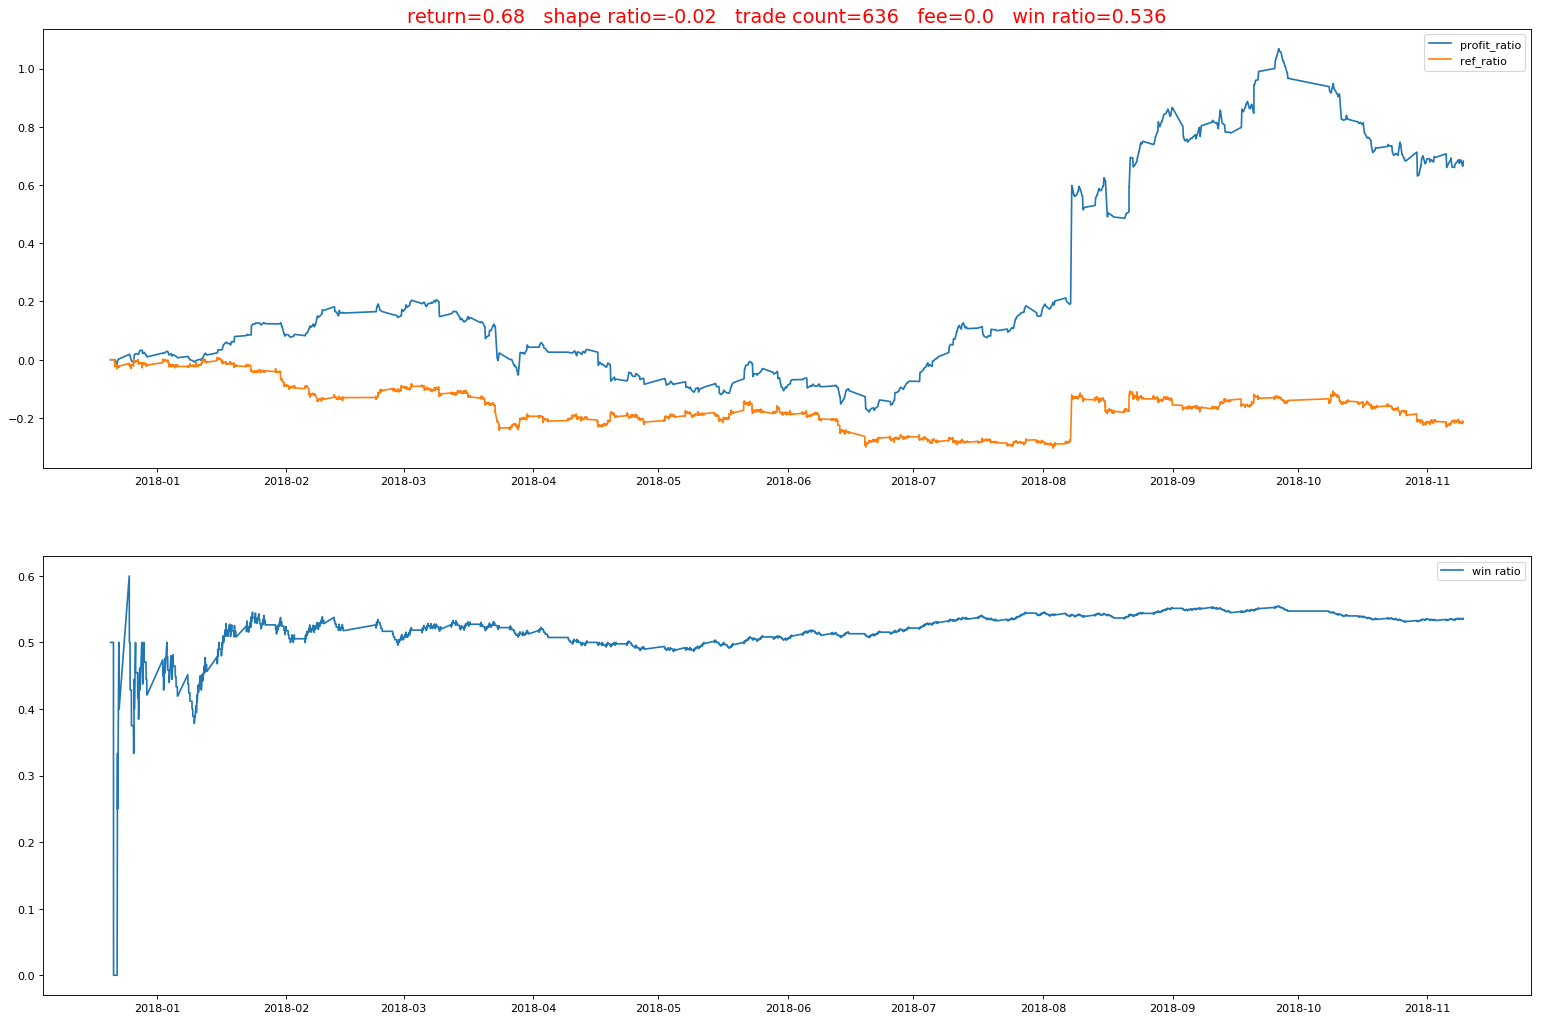

In [8]:
#回测商品参数 init_cash初始资金，hand每手几吨，tip最小变动价格，leverage_ratio杠杆率，use_cash_pect风险暴露比例，comm_ratio手续费率，slip滑点个数，slip_ratio滑点机率
#注意：目前betsize backtest没有设置滑点，滑点加入手续费，按照手续费*2设置手续费
import sys
from collections import deque
from matplotlib import pyplot as plt
from matplotlib import gridspec

SHFE_RU = {'init_cash': 500000, 'hand': 10,   'tip': 5,    'leverage_ratio': 0.12,  'use_cash_pect': 0.2,'comm_ratio': 0.0000, 'slip': 1, 'slip_ratio':0.2}


class BackTest(object):
    def __init__(self, modelobj, bars, productlabel):
        '''
        :param modelobj:    object， 模型对象
        :param bars:        datafarme，含原始价格的{open,high,low,close,volume},metalabel增加side列(无side列无metalabel，则采用预测信号正负做多或者做空）
        注意：bars和idcs是分开的，bar提供基本变量用于回测计算，idcs提供预测用的属性
        '''

        # 参数（与模型训练的时候对起来）
        self.thru_left    =   0.58    #0.58  # 左边标签的概率阈值
        self.thru_right   =   0.58    #0.58  # 右边标签的概率阈值
        self.profit_taken = 0.03   #止盈
        self.stop_loss    = 0.05   #止损
        self.numMinutes   = 240    #超时分钟

        # 初始值，商品特性
        self.bkparm = productlabel

        # 当前值
        self.now_positions = [0, 0, None, None, 0.0, 0.0, 0.0]  # [方向：1做多，-1做空 | 量：手数 | 建仓时间 | 超时时间 | 建仓价格 | 止盈价格 | 止损价格]
        self.now_cash   = self.bkparm['init_cash']
        self.now_equity = self.bkparm['init_cash']
        self.now_wincnt = 0.0
        self.now_opencnt = 0
        self.barcnt = 0
        self.allfee = 0.0
        self.slipfee= 0.0
        self.shape=0.0   #夏普比率

        # 历史值
        self.hist_positions = pd.DataFrame(index=bars.index,
                                           columns=['side', 'vol', 'open_time', 'timeout_time', 'proftake_price',
                                                    'stoploss_price'])
        self.hist_refratio = pd.Series(data=0.0, index=bars.index)
        self.hist_equity   = pd.Series(data=self.bkparm['init_cash'], index=bars.index)
        self.hist_profratio = pd.Series(data=0.0, index=bars.index)
        self.hist_winratio = pd.Series(data=0.5, index=bars.index)
        self.lastbar = None

        # 输入值
        self.modelobj = modelobj
        self.modelobj.n_jobs = 1  # 预测阶段，避免用多进程，起停多进程反而浪费时间
        self.bars = bars


        # 模型用预测序列
        self.init_modelbars=50
        self.modelbars = deque([], self.init_modelbars)

        plt.ion()

    def close_position(self, bar):
        openside = self.now_positions[0]
        openvol = self.now_positions[1]
        opentime = self.now_positions[2]
        outtime = self.now_positions[3]
        openprice = self.now_positions[4]
        protkn_price = self.now_positions[5]
        stoploss_price = self.now_positions[6]

        if openside == 1:
            profit = (bar.close - openprice) * openvol * self.bkparm['hand']
            if profit > 0.0:
                self.now_wincnt += 1
            self.now_cash += (profit + openprice * openvol * self.bkparm['hand'] * self.bkparm[
                'leverage_ratio'])  # 多平
        elif openside == -1:
            profit = (openprice - bar.close) * openvol * self.bkparm['hand']
            if profit > 0.0:
                self.now_wincnt += 1
            self.now_cash += (profit + openprice * openvol * self.bkparm['hand'] * self.bkparm[
                'leverage_ratio'])  # 空平

        self.now_cash -= (openvol * self.bkparm['hand'] * bar.close * self.bkparm['comm_ratio'])  # 减去手续
        self.now_positions = 0
        self.now_equity = self.now_cash
        self.now_positions = [0, 0, None, None, 0.0, 0.0, 0.0]  # 重置position
        print('信号平仓，时间=%s，量=%d，净值=%f' % (bar.name.strftime('%Y-%m-%d %H:%M:%S'), openvol, self.now_equity))
        print(50 * '-')

    def onbar(self, bar):
        #追加缓存
        self.modelbars.append(bar)

        # 1.预测
        ypred = self.modelobj.predict(np.array(self.modelbars))
        yprob = self.modelobj.predict_proba(np.array(self.modelbars))

        self.lastbar = bar

        # 2.建仓，只判断yprob[-1][1]是因为第二个模型只关注1分类进行信号执行
        if self.now_positions[1] == 0:
            # 根据是否有side设置，决定开平仓方向
            metaopenside=0

            if ypred[-1] == 1 and yprob[-1][1] >= self.thru_right:
                metaopenside=1  #做多
            elif ypred[-1] == -1 and yprob[-1][0] >= self.thru_left:
                metaopenside=-1 #做空

            if metaopenside==1:  #做多
                buynum = int((self.now_cash * self.bkparm['use_cash_pect']) / (
                        self.bkparm['leverage_ratio'] * bar.close * self.bkparm['hand']))
                if self.profit_taken > 0.0:
                    pt = bar.close * (1 + self.profit_taken)
                else:
                    pt = 3 * bar.close
                if self.stop_loss > 0.0:
                    sl = bar.close * (1 - self.stop_loss)
                else:
                    sl = 0.0
                self.now_positions = [1, buynum, bar.name, bar.name + pd.Timedelta(minutes=self.numMinutes), bar.close, pt,sl]
                self.now_cash -= buynum * bar.close * self.bkparm['hand'] * self.bkparm['leverage_ratio']
                self.now_cash -= buynum * bar.close * self.bkparm['hand'] * self.bkparm['comm_ratio']  # 去掉手续费
                self.allfee   += buynum * bar.close * self.bkparm['hand'] * self.bkparm['comm_ratio']  # 记录手续费
                self.now_equity = self.now_cash + buynum * self.bkparm['hand'] * bar.close * self.bkparm['leverage_ratio']
                print('开多，时间=%s，量=%d' % (self.now_positions[2].strftime('%Y-%m-%d %H:%M:%S'), self.now_positions[1]))
                self.now_opencnt += 1
                return
            elif metaopenside==-1:  #做空
                sellnum = int((self.now_cash * self.bkparm['use_cash_pect']) / (
                        self.bkparm['leverage_ratio'] * bar.close * self.bkparm['hand']))
                if self.profit_taken > 0.0:
                    pt = bar.close * (1 - self.profit_taken )
                else:
                    pt = 0.0
                if self.stop_loss > 0.0:
                    sl = bar.close * (1 + self.stop_loss )
                else:
                    sl = 3 * bar.close
                self.now_positions = [-1, sellnum, bar.name, bar.name + pd.Timedelta(minutes=self.numMinutes), bar.close, pt,sl]
                self.now_cash -= sellnum * bar.close * self.bkparm['hand'] * self.bkparm['leverage_ratio']
                self.now_cash -= sellnum * bar.close * self.bkparm['hand'] * self.bkparm['comm_ratio']  # 去掉手续费
                self.allfee   += sellnum * bar.close * self.bkparm['hand'] * self.bkparm['comm_ratio']  # 记录手续费
                self.now_equity = self.now_cash + sellnum * self.bkparm['hand'] * bar.close * self.bkparm['leverage_ratio']
                print('开空，时间=%s，量=%d' % (self.now_positions[2].strftime('%Y-%m-%d %H:%M:%S'), self.now_positions[1]))
                self.now_opencnt += 1
                return
            else:
                pass

        # 3.止盈止损(搜索本bar内tick，触线出局）
        if self.now_positions[1] != 0:
            openside = self.now_positions[0]
            openvol = self.now_positions[1]
            opentime = self.now_positions[2]
            outtime = self.now_positions[3]
            openprice = self.now_positions[4]
            protkn_price = self.now_positions[5]
            stoploss_price = self.now_positions[6]

            # if self.now_positions[0] == 1:  # 平多
            #     stoploss_price -= self.bkparm['slip'] * self.bkparm['tip']
            #     pminidx = barticks[barticks >= protkn_price].index.min()
            #     sminidx = barticks[barticks <= stoploss_price].index.min()
            # elif self.now_positions[0] == -1:
            #     stoploss_price += self.bkparm['slip'] * self.bkparm['tip']
            #     pminidx = barticks[barticks <= protkn_price].index.min()
            #     sminidx = barticks[barticks >= stoploss_price].index.min()


            if bar.close>=np.max([protkn_price,stoploss_price]) or bar.close<=np.min([protkn_price,stoploss_price]):
                needclose=True
            elif bar.name>=outtime:
                needclose=True
            else:
                needclose=False

            if needclose:  # 需要平仓
                closeprice = bar.close
                if openside == 1:
                    profit = (closeprice - openprice) * openvol * self.bkparm['hand']
                    if profit > 0.0:
                        self.now_wincnt += 1
                    self.now_cash += (profit + openprice * openvol * self.bkparm['hand'] * self.bkparm[
                        'leverage_ratio'])  # 多平
                elif openside == -1:
                    profit = (openprice - closeprice) * openvol * self.bkparm['hand']
                    if profit > 0.0:
                        self.now_wincnt += 1
                    self.now_cash += (profit + openprice * openvol * self.bkparm['hand'] * self.bkparm[
                        'leverage_ratio'])  # 空平

                self.now_cash -= (openvol * self.bkparm['hand'] * closeprice * self.bkparm['comm_ratio'])  # 减去手续
                self.allfee   += (openvol * self.bkparm['hand'] * closeprice * self.bkparm['comm_ratio'])  # 记录手续费
                self.now_positions = 0
                self.now_equity = self.now_cash
                self.now_positions = [0, 0, None, None, 0.0, 0.0, 0.0]
                print('止盈止损平仓，时间=%s，量=%d，净值=%f，总手续费=%f'% (bar.name.strftime('%Y-%m-%d %H:%M:%S'), openvol, self.now_equity, self.allfee))
                print(50 * '-')
                sys.stdout.flush()
        return

    # 收集统计信息
    def update_stat(self, bar):
        self.barcnt += 1
        self.hist_positions.loc[bar.name, 'side'] = self.now_positions[0]
        self.hist_positions.loc[bar.name, 'vol'] = self.now_positions[2]
        self.hist_positions.loc[bar.name, 'open_time'] = self.now_positions[3]
        self.hist_positions.loc[bar.name, 'timeout_time'] = self.now_positions[4]
        self.hist_positions.loc[bar.name, 'proftake_price'] = self.now_positions[5]
        self.hist_positions.loc[bar.name, 'stoploss_price'] = self.now_positions[6]

        self.hist_equity.loc[bar.name] = self.now_equity
        self.hist_profratio[bar.name] = self.now_equity / self.bkparm['init_cash'] - 1
        self.hist_refratio[bar.name] = bar.close / self.bars.iloc[self.init_modelbars].close - 1

        self.hist_winratio[bar.name] = self.now_wincnt / (0.001 + self.now_opencnt)

        es=pd.Series(self.hist_equity).loc[self.modelbars[0].name:bar.name]   #找到已经回测的时间段
        ret=(es/es.shift(1)).dropna() - 1.0
        if ret.std()!=0. :
            self.shape=ret.mean()/ret.std()
        else:
            self.shape=0.

        # if self.barcnt % 200 == 0:
        #     self.draw_pic()
        #     pass

    # 画图
    def draw_pic(self):
        plt.close()
        plt.figure(num=1, figsize=(24, 16), dpi=80)
        # picdf=pd.concat([self.hist_profratio,self.hist_refratio])
        # picdf.columns=['hist_profratio','hist_refratio']
        # picdf=picdf[picdf['hist_profratio']!=0.0]
        # plt.plot(picdf)

        ax1 = plt.subplot(2, 1, 1)
        plt.plot(self.hist_profratio, label='profit_ratio')
        plt.plot(self.hist_refratio, label='ref_ratio')
        handles1, labels1 = ax1.get_legend_handles_labels()
        ax1.legend(handles1, labels1)
        #打印抬头
        plt.title('return='+str(round((self.now_equity/self.bkparm['init_cash'])-1.0,2))+
                  '   shape ratio='+str(round(self.shape,2))+'   trade count='+str(self.now_opencnt)+
                  '   fee=' +str(round(self.allfee,2))+
                  '   win ratio='+str(round(self.now_wincnt / (0.001 + self.now_opencnt),3)),color='red',size='xx-large')

        ax2 = plt.subplot(2, 1, 2)
        plt.plot(self.hist_winratio, label='win ratio')
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(handles2, labels2)

        plt.draw()
        plt.pause(0.05)

        return

    def run_onbar(self):
        for j in range(self.init_modelbars):
            self.modelbars.append(self.bars.iloc[j, :])
        runbars = self.bars[self.init_modelbars:]

        for i in range(len(runbars)):
            self.onbar(runbars.iloc[i, :])
            self.update_stat(runbars.iloc[i, :])

        self.draw_pic()

        print('总交易次数=%d'% self.now_opencnt)
        print('总手续费=%f'%self.allfee)
        print('总胜率=%f'%(self.now_wincnt/(0.001 + self.now_opencnt)))
        print('夏普比率=%f'%self.shape)

bt=BackTest(model,Xtest,SHFE_RU)
bt.run_onbar()

上面大图上图是5分钟策略的收益率图（蓝线收益率，橙线是商品本身价格走势），下面是胜率附图，通过回测程序我们模拟了样本外实际情况下的策略表现。